# Подготовительные штуки

In [11]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)

Блок кода для визуализации процесса обучения модели: 

In [12]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag : str, value)-> None:
    self._history_dict[tag].append(value)

  def display_plot(self)-> None:
    clear_output()
    n_keys = len(self._history_dict)
    fig, ax = plt.subplots(n_keys, 1, figsize=(12, 3*n_keys))
    for key_idx, key in enumerate(self._history_dict.keys()):
      history_len = len(self._history_dict[key])
      if n_keys == 1:
        ax.plot(self._history_dict[key], color='c', marker="X")
        ax.set_ylabel(key)
        ax.set_xlabel('step')
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))
      elif n_keys > 1:
        ax[key_idx].plot(self._history_dict[key], color='c', marker="X")
        ax[key_idx].set_ylabel(key)
        ax[key_idx].set_xlabel('step')
        ax[key_idx].set_xticks(np.arange(history_len))
        ax[key_idx].set_xticklabels(np.arange(history_len))
    fig.tight_layout()
    plt.show()

Пример использования кода визуализации:

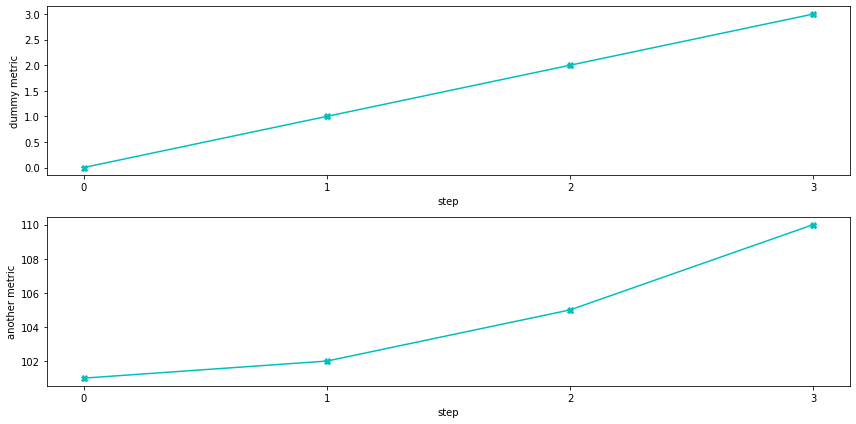

In [13]:
pp = ProgressPlotter()

for i in range(4):
  pp.add_scalar(tag='dummy metric', value=i)
  pp.add_scalar(tag='another metric', value=i**2 + 101)
  pp.display_plot()

# Задание 1. Линейный классификатор и подбор learning rate

В этом задании пишу линейный классификатор и обучаю его на датасете CIFAR10.

Для оценки точности во время обучения завожу экземпляр класса ProgressPlotter.

В конце минимально меняю learning rate, но рил без серьезного варьирования.



## Скачивание датасета cifar-10

In [14]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !wget https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX02/cifar-10-python.tar.gz
    !tar -xzf cifar-10-python.tar.gz
    !ls -l
    top_path = "/content"
else:
    top_path = ""
    print("You didn't run code in colab")

--2023-01-10 10:03:53--  https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX02/cifar-10-python.tar.gz
Resolving edunet.kea.su (edunet.kea.su)... 188.44.53.138
Connecting to edunet.kea.su (edunet.kea.su)|188.44.53.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/octet-stream]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  10.1MB/s    in 18s     

2023-01-10 10:04:13 (9.15 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]

total 333016
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py
-rw-r--r-- 1 root root 170498071 Nov 28 11:03 cifar-10-python.tar.gz
-rw-r--r-- 1 root root 170498071 Nov 28 11:03 cifar-10-python.tar.gz.1
drwxr-xr-x 1 root root      4096 Jan  5 14:34 sample_data


Посмотрим на данные

In [15]:
import numpy as np
import random

# Recreating python object from the bytecode of the batches
def unpickle(file, encoding='bytes'):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding=encoding)
    return dict

def load_train_data():
    x_train = [] 
    y_train = [] 
    for i in range(1, 6):
        raw = unpickle(f'cifar-10-batches-py/data_batch_{i}')
        x_train.append(raw[b'data']) 
        y_train.append(raw[b'labels']) 
    x_train = np.vstack(x_train)
    y_train = np.hstack(y_train)
    return x_train, y_train

x_train, y_train = load_train_data()

#  load test data
test = unpickle(top_path + "/cifar-10-batches-py/test_batch")
x_test = np.array(test[b'data'])
y_test = np.array(test[b'labels'])

# load classes names 
meta = unpickle(top_path + "/cifar-10-batches-py/batches.meta", 'utf-8')
labels= meta['label_names']
labels_eng = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# display data(shape [..., 3072])
print("labels: ", labels)
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


И отобразим их графически

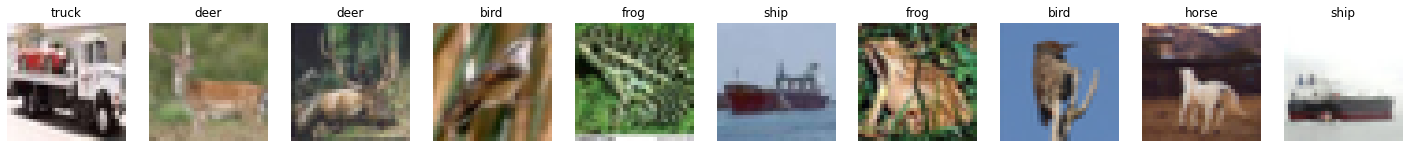

In [16]:
import matplotlib.pyplot as plt
import random

def to_img(arr):
    # Transform data from vector to array with 3 channel(RGB) 
    img = arr.reshape(3, 32, 32).transpose(1, 2, 0).astype(int)
    return img

plt.rcParams["figure.figsize"] = (25, 10)
image_to_display = 10
j = 1
for i in random.sample(range(0, len(x_train)), image_to_display):
    plt.subplot(1, image_to_display,j)
    plt.imshow(to_img(x_train[i]))
    plt.axis('off')
    plt.title(labels[int(y_train[i])])
    j += 1 

Зададим функцию для проверки точности модели

In [17]:
from sklearn.metrics import accuracy_score

# func to compute accuracy
def validate(model, x_test, y_test):
    y_predicted = []
    for i, sample in enumerate(x_test):
        index = model.predict(sample)
        y_predicted.append(index) 
    return accuracy_score(y_test, y_predicted)  

Напишем классификатор

In [18]:
class LinearClassifier():
    def __init__(self, labels):
        self.labels = labels
        self.classes_num = len(labels)
        # Generate a random weight matrix of small numbers
        # Number of weights changed from 3072 to 3073 for implement bias trick
        self.W = np.random.randn(3073, self.classes_num) * 0.0001
        self.batch_size = 256
        
    def run_epoch(self, x, y, learning_rate=1e-7, train_flag=True):
        loss = 0.0
        x_len = x.shape[0]
        indexes = list(range(x_len))

        # if train mode make shuffle
        if train_flag:
            random.shuffle(indexes)
        for i in range(0, x_len, self.batch_size): 
            #Batch generation
            idx = indexes[i : i + self.batch_size]
            x_batch = x[idx]
            y_batch = y[idx]
            # Bias trick
            x_batch = np.hstack([x_batch, np.ones((x_batch.shape[0], 1))])
            loss_val, grad = self.loss(x_batch, y_batch)
            loss += loss_val
            # Weight updating
            if train_flag:
              self.W -= learning_rate * grad
        return loss / x_len

    def loss(self, x, y):
        current_batch_size = x.shape[0]
        loss = 0.0
        dW = np.zeros(self.W.shape)
        for i in range(current_batch_size):
            scores = x[i].dot(self.W)
            correct_class_score = scores[int(y[i])]
            above_zero_loss_count = 0
            for j in range(self.classes_num):
                if j == y[i]:
                    continue
                margin = scores[j] - correct_class_score + 1 # note delta = 1
                if margin > 0:
                    above_zero_loss_count += 1
                    loss += margin
                    dW[:, j] += x[i] # We summarize it because grad computed over a batch and
                                    # will de divided by number of examples in this batch
            dW[:, int(y[i])] -= above_zero_loss_count * x[i]
        loss /= current_batch_size
        dW /= current_batch_size
        # Reqularization gone :(
        return loss, dW

    def predict(self, x):
        x = np.append(x, 1) # bias trick
        scores = x.dot(self.W)
        return np.argmax(scores) 

In [19]:
pp = ProgressPlotter()

from sklearn.metrics import accuracy_score

model = LinearClassifier(labels)

#acc=[]
#loss=[]
#for epoch in range(30):
#    loss.append(model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True))
#    scr=validate(model, x_test, y_test)
#    acc.append(scr)
#    print("epoch =",epoch,"  ||   accuracy=",scr)

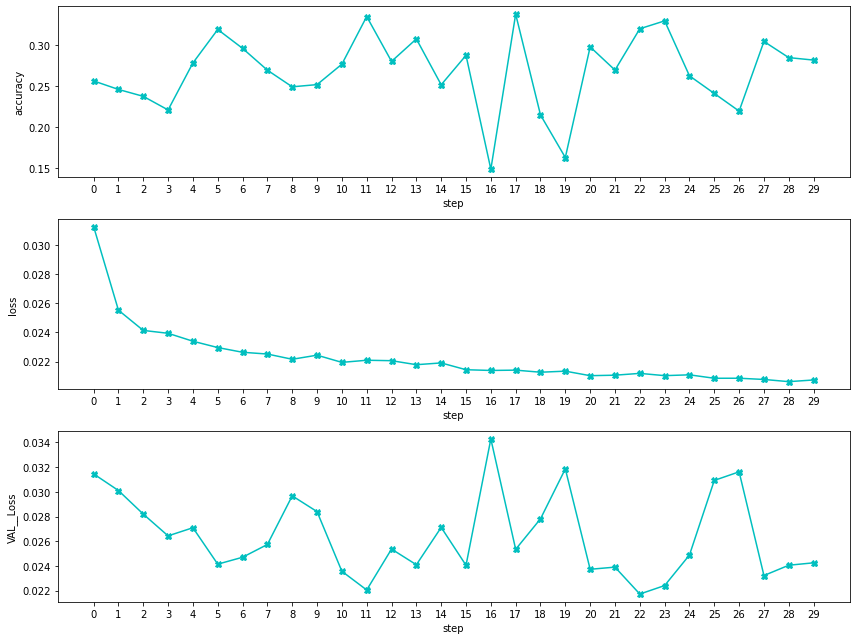

In [20]:
pp = ProgressPlotter()

from sklearn.metrics import accuracy_score

model = LinearClassifier(labels)


for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
    acc=validate(model, x_test, y_test)
    v_loss=model.run_epoch(x_test,y_test,learning_rate=1e-7, train_flag=False)
    pp.add_scalar(tag='accuracy', value=acc)
    pp.add_scalar(tag='loss', value=loss)
    pp.add_scalar(tag='VAL__Loss', value=v_loss)
    pp.display_plot()

Теперь чуть поменяем learning rate (на плюс минус порядок):


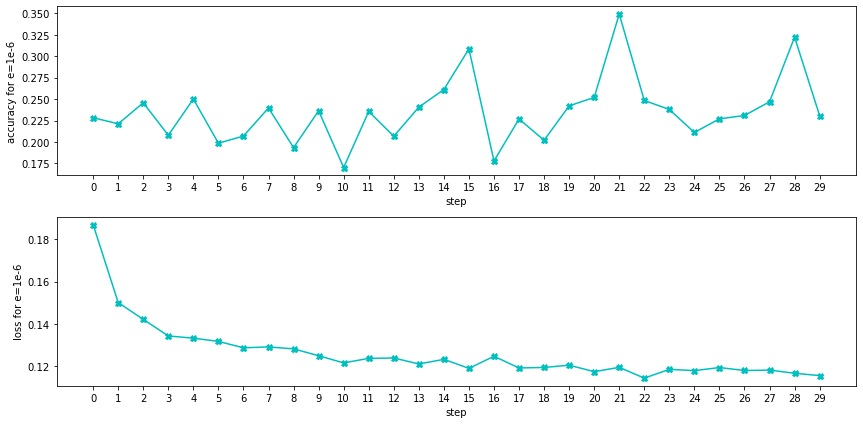

In [21]:
pp1 = ProgressPlotter()
model = LinearClassifier(labels)

for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-6, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp1.add_scalar(tag='accuracy for e=1e-6', value=acc)
    pp1.add_scalar(tag='loss for e=1e-6', value=loss)
    pp1.display_plot()




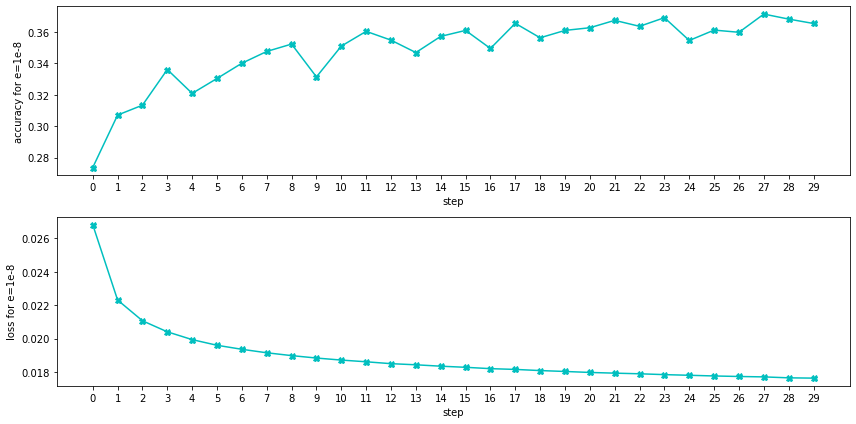

In [22]:
pp2 = ProgressPlotter()
model = LinearClassifier(labels)

for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-8, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp2.add_scalar(tag='accuracy for e=1e-8', value=acc)
    pp2.add_scalar(tag='loss for e=1e-8', value=loss)
    pp2.display_plot()


Видим, что с learning_rate=1e-8 работает круче -- точность выше и даже лосс уменьшается очень монотонно (лучше, чем при 1e-6).

# Задание 2. Добавить L2 регуляризацию к лосс-функции

Все же с нашим классификатором что-то не так. Хочу это подправить.

Параметр лямбда (`reg_strength`) буду задавать в конструкторе.
Буду наследоваться от `LinearClassifier` и, как всегда, юзать экземпляр класса ProgressPlotter для отображения логов.

In [23]:
class LinearClassifierWithReg(LinearClassifier):
  def __init__(self, labels, reg_strength):
      super().__init__(labels)
      self.reg = reg_strength

  def loss(self, x, y):
      current_batch_size = x.shape[0]
      loss = 0.0
      dW = np.zeros(self.W.shape)
      for i in range(current_batch_size):
          scores = x[i].dot(self.W)
          correct_class_score = scores[int(y[i])]
          above_zero_loss_count = 0
          for j in range(self.classes_num):
              if j == y[i]:
                  continue
              margin = scores[j] - correct_class_score + 1 # note delta = 1
              if margin > 0:
                  above_zero_loss_count += 1
                  loss += margin
                  dW[:, j] += x[i] # We summarize it because grad computed over a batch and
                                  # will de divided by number of examples in this batch
          dW[:,int(y[i])] -= above_zero_loss_count * x[i]
      loss /= current_batch_size

      loss += self.reg * np.sum(self.W * self.W)
      # We must take derivative of regularization too
      # Gradient computed over the batch

      dW = dW+self.reg*2*self.W # Так ведь? Добавив регуляризацию, производная по k-ому весу вырастает на lambda*d(sum(w_i^2))/dw_k=lambda*2*w_k.
      dW /= current_batch_size
          
      return loss, dW


Обучаем новую модель. Сначала с лямбда я просто поиграюсь, потом уже поищу серьезно на кросс-валидации.

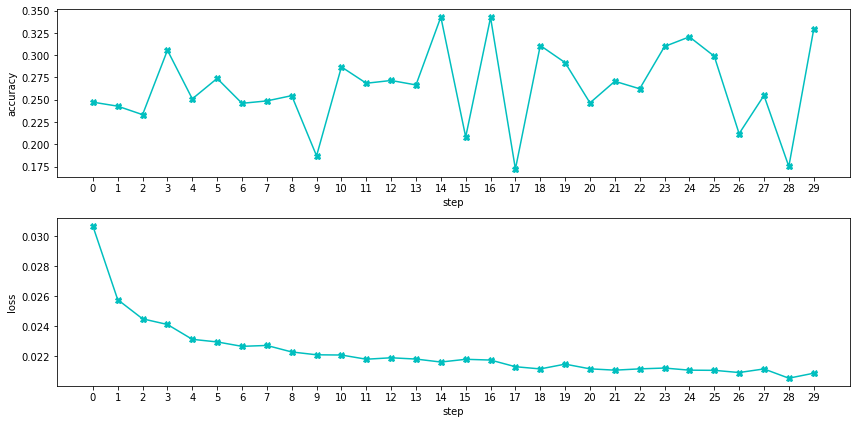

In [24]:
pp = ProgressPlotter()

model = LinearClassifierWithReg(labels,0.01)


pp = ProgressPlotter()


for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp.add_scalar(tag='accuracy', value=acc)
    pp.add_scalar(tag='loss', value=loss)
    pp.display_plot()

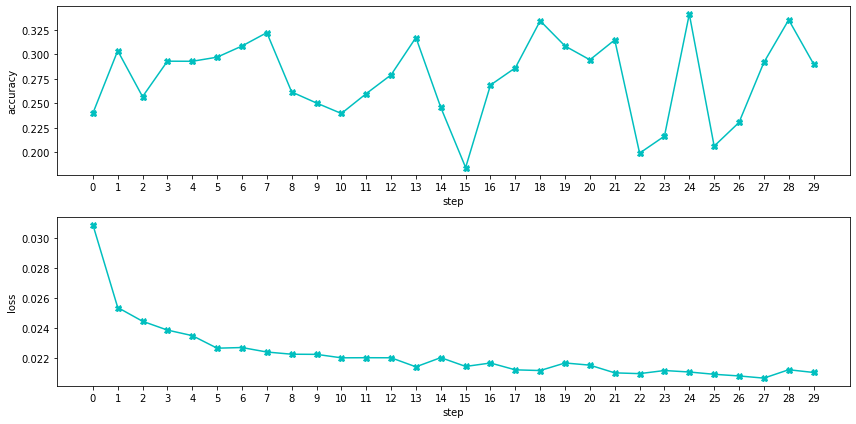

In [25]:
pp = ProgressPlotter()

model = LinearClassifierWithReg(labels,0.3)


pp = ProgressPlotter()


for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp.add_scalar(tag='accuracy', value=acc)
    pp.add_scalar(tag='loss', value=loss)
    pp.display_plot()

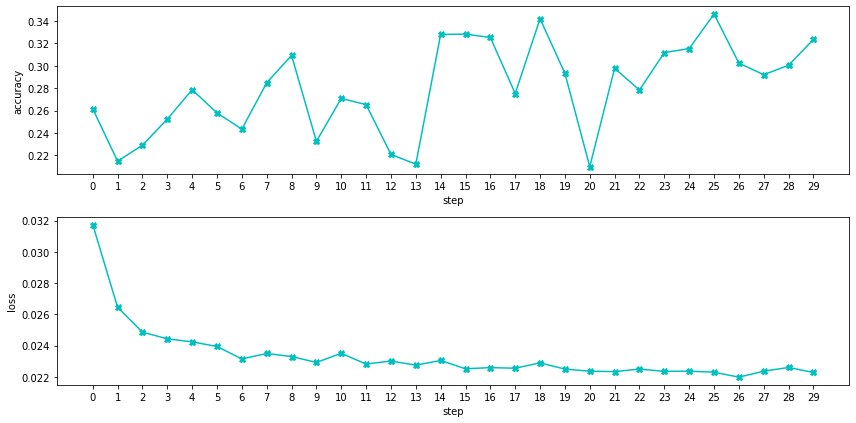

In [26]:
pp = ProgressPlotter()

model = LinearClassifierWithReg(labels,500)


pp = ProgressPlotter()


for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp.add_scalar(tag='accuracy', value=acc)
    pp.add_scalar(tag='loss', value=loss)
    pp.display_plot()

## Подбор лямбда (regularization strength) при помощи кросс-валидации.


**Примечание:** для ускорения расчетов буду использовать для кросс-валидации только 10 000 элементов из train выборки и 15 эпох.

In [27]:
import numpy as np
from sklearn.model_selection import KFold

def cross_validate(reg, x, y, n_splits=3):
    """
    Сross-validation for one value regularization strength.

    :param reg: regularization strength
    :param x: features (train data)
    :param y: labels (train data)
    :param n_splits: number of folds

    :return acc_mean: accuracy mean
    :return acc_std: accuracy std
    """
    cv=KFold(n_splits, shuffle=True, random_state=42)

    acc=[]
    loss=[]
    for train_index, test_index in cv.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LinearClassifierWithReg(labels,reg)
        for epoch in range(15):
            loss_temp=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
            acc_temp=validate(model, x_test, y_test)
        loss.append(loss_temp)
        acc.append(acc_temp) 
        #print("На данном сплите accuracy =",acc_temp,"    loss =",loss_temp)

    acc=np.array(acc)
    loss=np.array(loss)        
    return acc.mean(), acc.std()

x_train=x_train[0:10000]
y_train=y_train[0:10000]
cross_validate(0.01,x_train,y_train,3)

(0.1644985134386264, 0.04568833113801621)

**Подбор параметров**

Для визуализации буду юзать `plt.errorbar`. Рассмотрю 5 значений в промежутке $10^{-3}$, $10^{-6}$. 

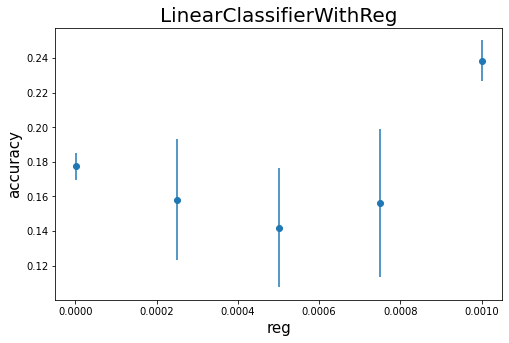

In [28]:
import matplotlib.pyplot as plt

acc_mean = []
acc_std = []

regs = np.linspace(1e-3, 1e-6, num=5)
for reg in regs:
    a, b=cross_validate(reg,x_train,y_train,3)
    acc_mean.append(a)
    acc_std.append(b)
    

plt.figure(figsize=(8, 5))
plt.title("LinearClassifierWithReg", size=20)
plt.errorbar(regs, acc_mean, yerr=acc_std, linestyle="None", fmt="-o")
plt.ylabel("accuracy", size=15)
plt.xlabel("reg", size=15)

plt.show()

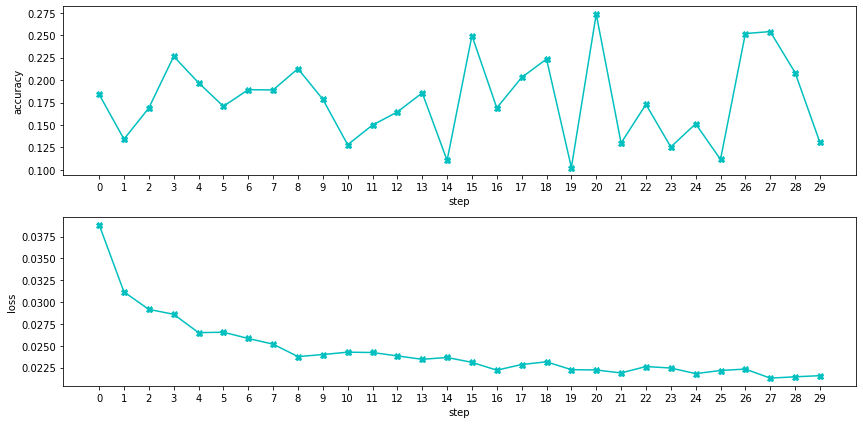

In [29]:
pp = ProgressPlotter()

model = LinearClassifierWithReg(labels,regs[4]) # взяли лучший параметр лямбда


pp = ProgressPlotter()


for epoch in range(30):
    loss=model.run_epoch(x_train,y_train,learning_rate=1e-7, train_flag=True)
    acc=validate(model, x_test, y_test)
    pp.add_scalar(tag='accuracy', value=acc)
    pp.add_scalar(tag='loss', value=loss)
    pp.display_plot()

# Задание 3. Линейная регрессия


Слегка формализую задачу. 

Ищем линию, которая наилучшим образом соответствует заданным точкам. Общее уравнение для прямой есть $f(x) = m⋅x + b$, где $m$ — наклон линии, а $b$ — ее сдвиг по $y$. Значит, решение линейной регрессии определяет значения для $m$ и $b$, так что $f(x)$ приближается как можно ближе к $y$.

Отобразим на графике случайные точки, расположенные в окрестности $y = 3⋅x + 2$

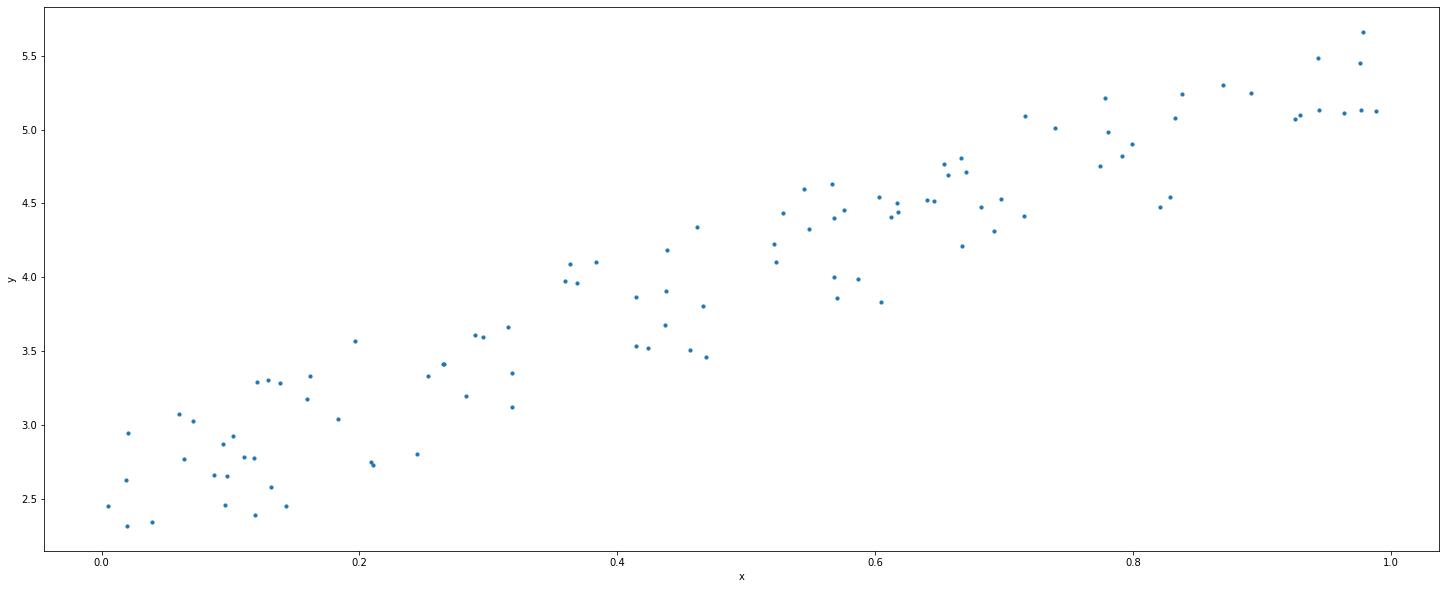

In [30]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.rand(100, 1)
y = 2 + 3 * x + np.random.rand(100, 1)

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Функция потерь -- MSE.

## Моя реализация линейной регрессии ручками

Не импортирую из sklearn, а делаю чисто на numpy.

# Короче, делаю так. #

$x$ - массив с тренировочными значениями во втором столбце и единицами в первом, т.е. $x$ имеет размерность $N$ x $2$.
Тогда параметры $m$ и $b$ записываем в виде вектора $\theta = [b, m]$ и получим:

$$
\hat{f}(х) = ах + b.
$$

Для всей выборки имеем:

$$
\hat{f}(x) = x \theta.
$$

В векторном виде MSE:

$$
\frac{1}{N}(\mathbf{y} - x \theta)^{T} (\mathbf{y} - x \theta) \rightarrow min_{\theta}
$$
Возьмем производную по $\theta$ и приравняем ее к 0:
$$
\mathbf{y} = x \theta
$$
поскольку $x$ не возведен в квадрат и не может быть инвертирован, мы умножаем обе части на $x^T$
$$
X^T \mathbf{y} = x^T x \theta
$$
матрица $x^T x$ почти всегда обратима, поэтому мы можем вычислить $\theta$:
$$
\hat{\theta} = (x^Tx)^{-1}x^T\mathbf{y}
$$

Estimated coefficients:
b_0 = [2.55808002] nb_1 = [2.93655106]
Root mean squared error:  0.0762332458287501
R2 score:  0.9038655568672764


Text(0, 0.5, 'y')

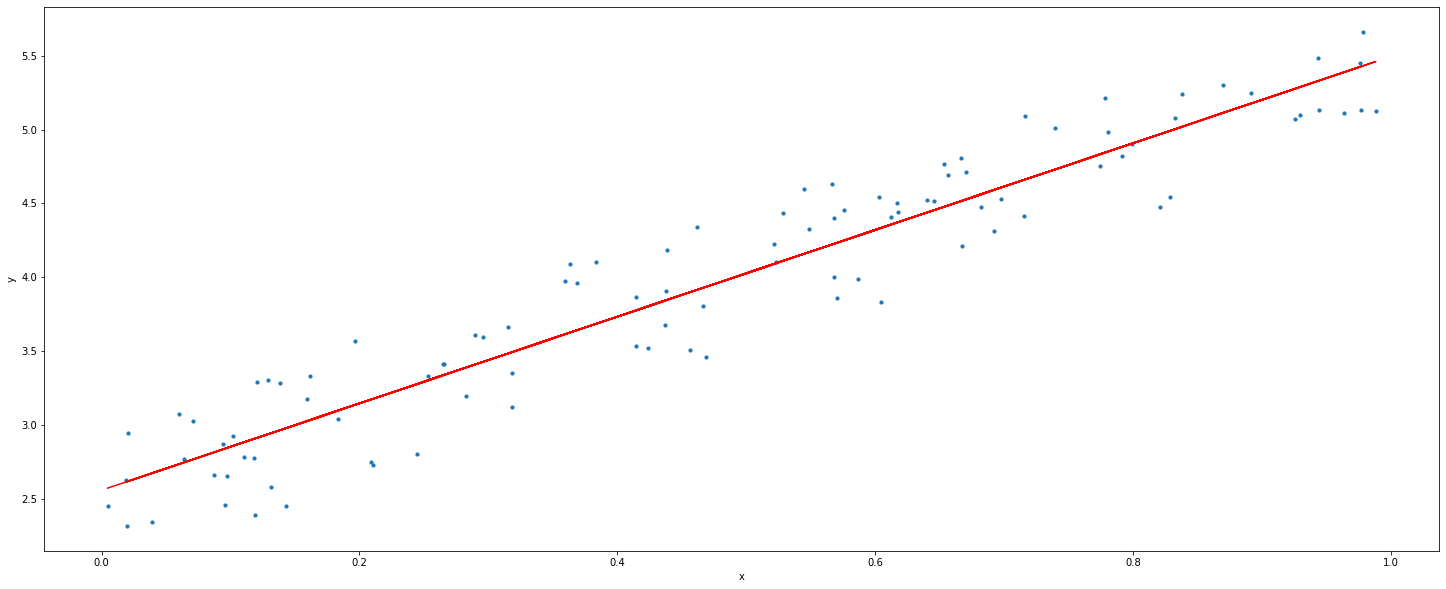

In [31]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
  
# Linear regression
#print(x.shape)
x=x.reshape(100)
#print(x.shape)

def find_theta(x, y): # f(x)=mx+b=X*theta, где X размерности Nx2 уже
# theta (наши кэфы) несложно выразить явно:
    x_ones = np.ones(shape = (x.shape[0], 2))
    x_ones[:, 1] = x
    theta = np.linalg.inv(x_ones.T.dot(x_ones)).dot(x_ones.T).dot(y)
    return theta

coefs = list(find_theta(x, y)) # = b, m





y_predicted = coefs[0] + coefs[1] * x

print("Estimated coefficients:\nb_0 = {} nb_1 = {}".format(coefs[0], coefs[1])) 
print('Root mean squared error: ', mean_squared_error(y, y_predicted))
print('R2 score: ', r2_score(y, y_predicted))


plt.scatter(x, y, s=10)
plt.plot(x, y_predicted, color='r')
plt.xlabel('x')
plt.ylabel('y')

# Задание 4. Множественная линейная регрессия

Уравнение множественной линейной регрессии имеет вид:

$y = b_0 + b_1 * x_1 + b_2 * x_2 + ... + b_n * x_n$

Т.е. по сути теперь рисуется гиперплоскость.

Конкретно здесь буду использовать множественную линейную регрессию для прогнозирования потребления газа (в миллионах галлонов) в 48 штатах США на основе: налогов на газ (в центах), дохода на душу населения (в долларах), шоссе с твердым покрытием (в милях) и доли населения, имеющей водительские права.


Тут уже буду импортировать из sklearn, как сука.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
dataset = pd.read_csv('https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX02/petrol_consumption.csv')
print(dataset.shape)
dataset.head()

(48, 5)


,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [34]:
dataset.describe()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.668333,4241.833333,5565.416667,0.570333,576.770833
std,0.950770,573.623768,3491.507166,0.055470,111.885816
min,5.000000,3063.000000,431.000000,0.451000,344.000000
25%,7.000000,3739.000000,3110.250000,0.529750,509.500000
50%,7.500000,4298.000000,4735.500000,0.564500,568.500000
75%,8.125000,4578.750000,7156.000000,0.595250,632.750000
max,10.000000,5342.000000,17782.000000,0.724000,968.000000


In [35]:
x = dataset[['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)']]
y = dataset['Petrol_Consumption']

In [36]:
# Split dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [37]:
# Multiple regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [38]:
y_pred = model.predict(x_test)

In [39]:
# Print table 
df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
print(df)

    y_test      y_pred
5      457  423.812737
31     554  588.484698
2      561  569.022002
11     471  448.795517
12     525  557.710133
47     524  561.680935
39     968  708.675832
33     628  613.256584
45     510  512.726548
15     635  598.930426


In [40]:
# Metrics 

#Mean Absolute Error
#Mean Squared Error
#Root Mean Squared Error

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  48.11532199256237
Mean Squared Error:  7411.262691282845
Root Mean Squared Error:  86.0886908442848
